Iterative SLS example with nonlinear dynamics for the state [joint_pos, joint_vel, end_pos, end_vel] and the control [joint_acc] with a quadratic cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches
from time import sleep
import os

import pinocchio as pin
from isls import iSLS
from isls.utils import get_double_integrator_AB, plot_robot, plot_robot_base
from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

### Problem setup in Pinocchio

In [2]:
# Load the urdf model
urdf_path = '/urdfs/3dof_robot.urdf'
model = pin.buildModelFromUrdf(os.getcwd() + urdf_path)
print('model name: ' + model.name)
# Create data required by the algorithms
data     = model.createData()
names = ["base", "link1", "link2", "link3", "ee"]
ids = []
for name in names:
    ids += [model.getFrameId(name)]

model name: 3dof


#### Functions for forward kinematics, jacobian and poses of each frame for plotting.

In [3]:
ee = ids[-1]
def pin_fk(q):
    if q.ndim == 1:
        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        return data.oMf[ee].translation
    else:
        batch_size = q.shape[0] 
        xs_log = np.zeros((batch_size,x_dim))
        for i in range(batch_size):
            # Perform the forward kinematics over the kinematic tree
            pin.forwardKinematics(model,data,q[i])
            pin.updateFramePlacements(model,data)
            # Print out the placement of each joint of the kinematic tree
            xs_log[i] = data.oMf[ee].translation
        return xs_log
    
def pin_jacobian(q):
    batch_size = q.shape[0] if q.ndim == 2 else 1
    if batch_size == 1:
        return pin.computeFrameJacobian(model,data,q,ee, pin.LOCAL_WORLD_ALIGNED)[:x_dim]
    else:
        J_log = np.zeros((batch_size,x_dim,q_dim))
        for i in range(batch_size):
            J_log[i] = pin.computeFrameJacobian(model,data,q[i],ee, pin.LOCAL_WORLD_ALIGNED)[:x_dim]
        return J_log[:,:x_dim]
    
def xs2plot(q):
    xs = np.zeros((q.shape[0], len(names), x_dim))
    for k,q_ in enumerate(q):
        pin.forwardKinematics(model,data,q_)
        pin.updateFramePlacements(model,data)
        for i,id_ in enumerate(ids):
            xs[k,i] =  data.oMf[id_].translation
    return xs[:,:,:2]

### Problem parameters 

In [4]:
q_dim = 3
x_dim = 3
state_dim = q_dim*2 + x_dim  #[q, dq, x]
u_dim = q_dim # [ddq]
T = 1.
horizon = 100
N = horizon
dt = T/N
print("dt:", dt)
d= state_dim
sls = iSLS(d, u_dim, N)

dt: 0.01


#### Forward model f(x, u) and its jacobian get_AB(x, u)

In [5]:
def f(x, u):
    q     = x[..., :q_dim]
    q_dot = x[..., q_dim:q_dim*2]
    x     = x[..., q_dim*2:]
    
    q     = q + q_dot*dt + 0.5*u*(dt**2)
    q_dot = q_dot + u*dt
    x     = pin_fk(q)
    return np.concatenate([q, q_dot, x],-1) 
# Set the forward model
sls.forward_model = f

In [6]:
A_, B_ = get_double_integrator_AB(q_dim, nb_deriv=2, dt=dt)
A = np.zeros((N, d, d))
B = np.zeros((N, d, u_dim))
A[:,:q_dim*2, :q_dim*2] = A_
B[:,:q_dim*2] = B_
def get_AB(x, u):
    q     = x[..., :q_dim]
    q_dot = x[..., q_dim:q_dim*2]
    J = pin_jacobian(q + q_dot*dt + 0.5*u*(dt**2))
    
    A[:,q_dim*2:, :q_dim] = J
    A[:,q_dim*2:, q_dim:q_dim*2] = J*dt
    
    B[:,q_dim*2:] = 0.5*J*(dt**2)
    return A,B

#### Task definition

In [7]:
# state = [q (3), q_dot (3), x (3), x_dot (3) ], x = [x,y,z]
final_pos = [1.5, 1., 0]
x_std = 1e6
u_std = 1e-4


x_final_target = np.concatenate([[0]*q_dim, [0]*q_dim, final_pos],-1)
viaQ_final = block_diag(*[np.diag([0]*q_dim + [x_std]*q_dim + [0] + [x_std] + [0])])


free_state = np.concatenate([np.zeros(q_dim*2+x_dim)], -1)
viaQ_free = block_diag(*[np.diag([0]*q_dim + [0]*q_dim + [0]*x_dim)])

zs = np.stack([free_state, x_final_target])
Qs = np.stack([viaQ_free, viaQ_final])


seq = np.zeros(N, dtype=np.int32)
seq[-1] = 1

In [8]:
# Set the cost variables if quadratic cost
sls.set_cost_variables(zs, Qs, seq, u_std)

### Solve the unconstrained problem

In [9]:
# initial guess
u0 = np.ones((N,u_dim))
q0 = np.array([ np.pi/3,-np.pi/2,-np.pi/4])

x_nom = []
u_nom = []
x_ = np.array(q0.tolist()+[0]*q_dim+pin_fk(q0).tolist())
for k in range(N):
    x_nom += [x_]
    u_nom += [u0[k]]
    x_ = f(x_[None], u0[k:k+1])[0]
    
x_nom = np.stack(x_nom)
u_nom = np.stack(u_nom)

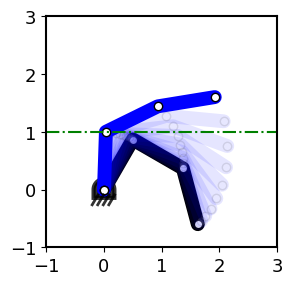

In [10]:
sls.reset() # reset if you reinitialize the problem
sls.nominal_values = x_nom, u_nom


fig,ax = plt.subplots(ncols=1, figsize=(6,3))
xlim = [-1,3]
ylim = [-1,3]
xs_plot = xs2plot(sls.x_nom[:,:q_dim])

plot_robot(xs_plot[0],ax=ax, xlim=xlim, ylim=ylim)

for k in range(1,N):
    if not k%10:
        plot_robot(xs_plot[k],color="b",alpha=0.1,ax=ax)
plot_robot(xs_plot[-1],color="b",alpha=1,ax=ax, robot_base=True)
ax.plot(xlim,[final_pos[1]]*2,"g-.", ms=10, label="goal")


In [11]:
# Reset the model
sls.reset()
# Initialize the model
sls.nominal_values = x_nom, u_nom
# Set to true to solve with dynamic programming, otherwise uses least square in batch form
dp = True

In [12]:
%%time
# Solve
sls.solve_ilqr(get_AB, max_ilqr_iter=30, max_line_search_iter=20, dp=dp)
# print(sls.cost_log)

Cost change is too low, cannot improve anymore at iteration 4 .
Wall time: 100 ms


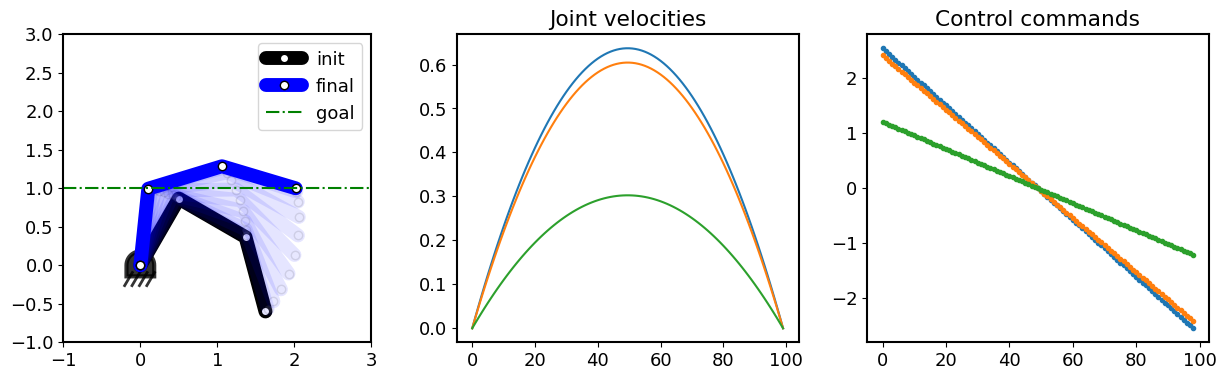

In [13]:
fig,ax= plt.subplots(ncols=3,figsize=(15,4))

ax[2].plot(sls.u_nom[:-1,:],".")
ax[2].set_title("Control commands")

ax[1].plot(sls.x_nom[:,3:6])
ax[1].set_title("Joint velocities")


xlim = [-1,3]
ylim = [-1,3]
xs_plot = xs2plot(sls.x_nom[:,:q_dim])
plot_robot(xs_plot[0],ax=ax[0], xlim=xlim, ylim=ylim, label="init", robot_base=True)

for k in range(1,N):
    if not k%10:
        plot_robot(xs_plot[k],color="b",alpha=0.1,ax=ax[0])
plot_robot(xs_plot[-1],color="b",alpha=1,ax=ax[0], label="final")
ax[0].plot(xlim,[final_pos[1]]*2,"g-.", ms=10, label="goal")
ax[0].legend()

## Solve the constrained problem

### Define constraints

In [18]:
### Control limits
lower_u = -6.
upper_u = 6.
def project_u(u):
    return project_bound(u, lower_u, upper_u)

### State limits
lower_x_final = 0.5
upper_x_final = 1.

lower_dx = -1.5
upper_dx = 1.5

def project_x(x):
    x_ = x.reshape(N, -1)
    x_[-1, q_dim*2] = project_bound(x_[-1, q_dim*2], lower_x_final, upper_x_final) #x dimension of the final x is constrained
    x_[:,q_dim:q_dim*2] = project_bound(x_[:,q_dim:q_dim*2], lower_dx, upper_dx) #all the velocities are constrained
    return x_.flatten()

In [19]:
# Problem parameters
Qr = np.zeros((N, d, d))
Qr[-1, q_dim*2, q_dim*2] = 1e1
Qr[:, q_dim:q_dim*2, q_dim:q_dim*2] = np.eye(q_dim)*1e-2

rho_u = 1e-3 # it will be converted to Rr inside
alpha = 1. # relaxation parameter for ADMM

In [20]:
%%time
sls.reset()
sls.nominal_values = x_nom, u_nom
log = sls.ilqr_admm(get_AB, project_x=project_x, project_u=project_u, max_admm_iter=10,
                        max_line_search=5, rho_x=Qr, rho_u=rho_u, alpha=alpha, threshold=1e-4, verbose=True, log=True)

ADMM residuals-> primal: 6.05e-02 dual: 4.35e-03
ADMM: Max iteration reached.
Iteration number  0 iLQR cost:  69920.11201338738
ADMM residuals-> primal: 2.04e-02 dual: 1.74e-03
ADMM: Max iteration reached.
Iteration number  1 iLQR cost:  105.71682104296634


C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ADMM residuals-> primal: 4.40e-03 dual: 7.16e-04
ADMM: Max iteration reached.
Iteration number  2 iLQR cost:  0.20116831024609685
ADMM residuals-> primal: 3.87e-04 dual: 4.35e-04
ADMM: Max iteration reached.
Iteration number  3 iLQR cost:  0.20001784929440103
ADMM residuals-> primal: 9.41e-04 dual: 6.76e-04
ADMM: Max iteration reached.
Iteration number  4 iLQR cost:  0.19963084535560188
Cost change is too low, cannot improve anymore at iteration 4 .
Wall time: 639 ms


Text(0.5, 0, '$t$')

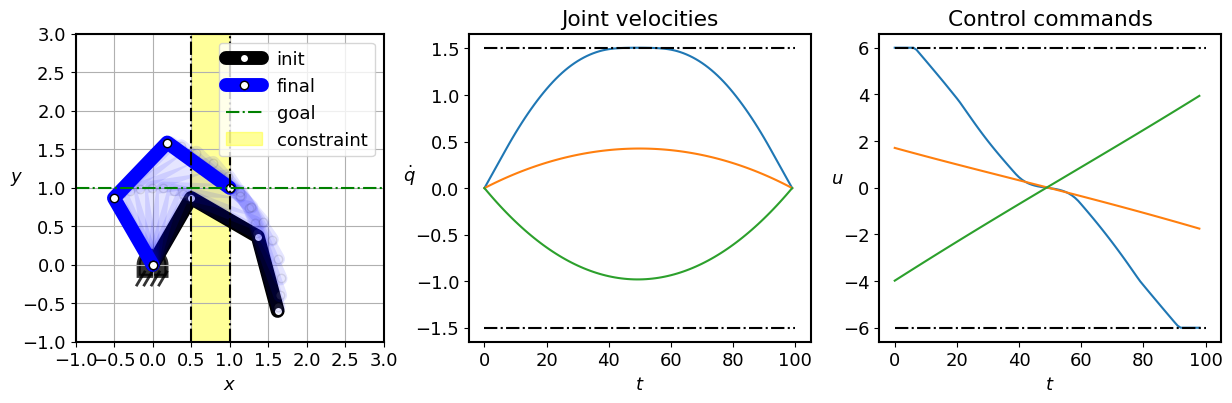

In [21]:

fig,ax= plt.subplots(ncols=3,figsize=(15,4))
ax[2].plot(sls.u_nom[:-1,:],"-")
ax[2].plot(np.linspace(0,N,10),[upper_u]*10, "-.",color="k")
ax[2].plot(np.linspace(0,N,10),[lower_u]*10, "-.",color="k")

ax[2].set_title("Control commands")

ax[1].plot(sls.x_nom[:,3:6])
ax[1].plot(np.linspace(0,N,10),[upper_dx]*10,  "-.",color="k")
ax[1].plot(np.linspace(0,N,10),[lower_dx]*10,  "-.",color="k")
ax[1].set_title("Joint velocities")


xlim = [-1,3]
ylim = [-1,3]
xs_plot = xs2plot(sls.x_nom[:,:q_dim])

plot_robot(xs_plot[0],ax=ax[0], color="k", xlim=xlim, ylim=ylim, label="init", robot_base=True)

for k in range(1,N):
    if not k%10:
        plot_robot(xs_plot[k],color="b",alpha=0.1,ax=ax[0],)
plot_robot(xs_plot[-1],alpha=1.,color="b", ax=ax[0], label="final")

ax[0].plot(xlim,[final_pos[1]]*2,"g-.", ms=10, label="goal")
ax[0].plot([upper_x_final]*2, ylim, "k-.")
ax[0].plot([lower_x_final]*2, ylim, "k-.")


ax[0].fill_betweenx(ylim, lower_x_final, upper_x_final, alpha=0.4, color="yellow", label="constraint")

ax[0].legend()

ax[0].grid()
ax[0].set_xticks(np.linspace(xlim[0], xlim[1], 9))


ax[0].set_ylabel(r"$y$", rotation=0)
ax[0].set_xlabel(r"$x$")

ax[1].set_ylabel(r"$\dot{q}$", rotation=0)
ax[1].set_xlabel(r"$t$")

ax[2].set_ylabel(r"$u$", rotation=0)
ax[2].set_xlabel(r"$t$")